<a href="https://colab.research.google.com/github/GabrielaRomoM/TAM-2025-2/blob/main/Tareas/TAM_IntroductionRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [16]:
import os
import sys
import sklearn
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Funciones

In [17]:
# Función para generar señales 1D
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time   = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

# Función para plot de curvas de aprendizaje
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

# Crear Y para cada horizonte
def get_Y_for_horizon(series, horizon):
    return series[..., horizon:horizon + n_steps, 0]

# Función métrica personalizada
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mse(Y_true[:, -1], Y_pred[:, -1])

# Ejercicios

## Ejercicio 1

Consultar el modelo y principio de optimización de los modelos de media móvil (Moving average - MA), autorregresivos de media móvil (Autorregresive moving average - ARMA) y autorregresivo integrado de media móvil (Autoregressive integrated moving average). ¿Cuáles son sus relaciones con los modelos Markovianos?

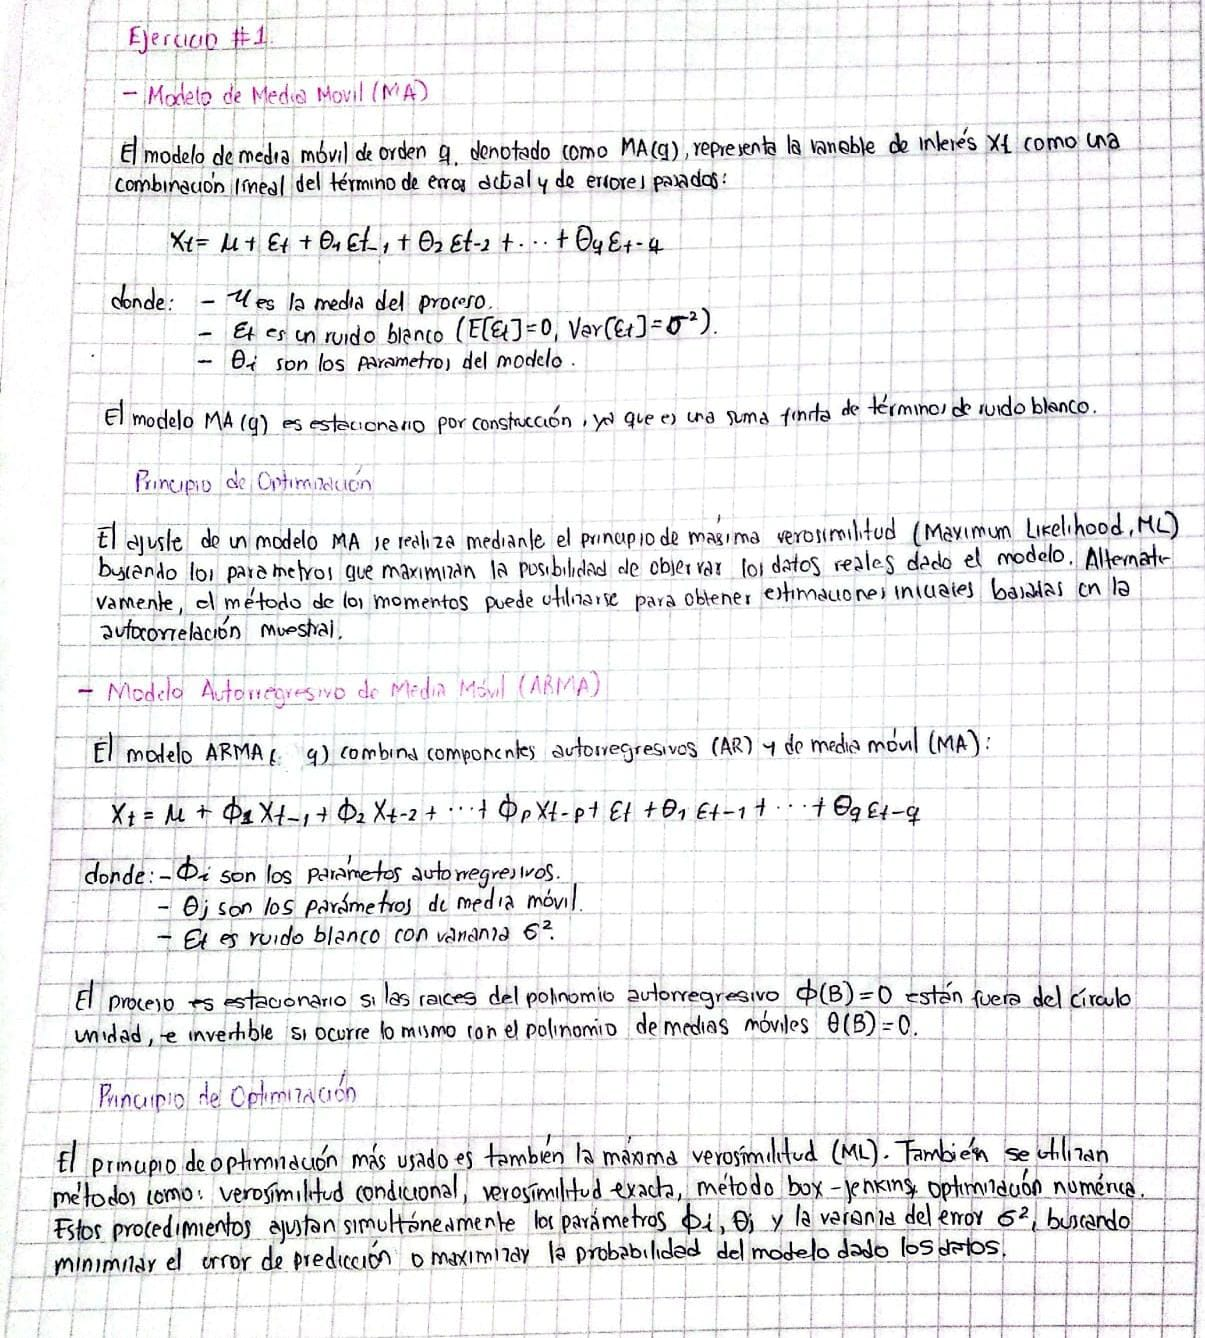  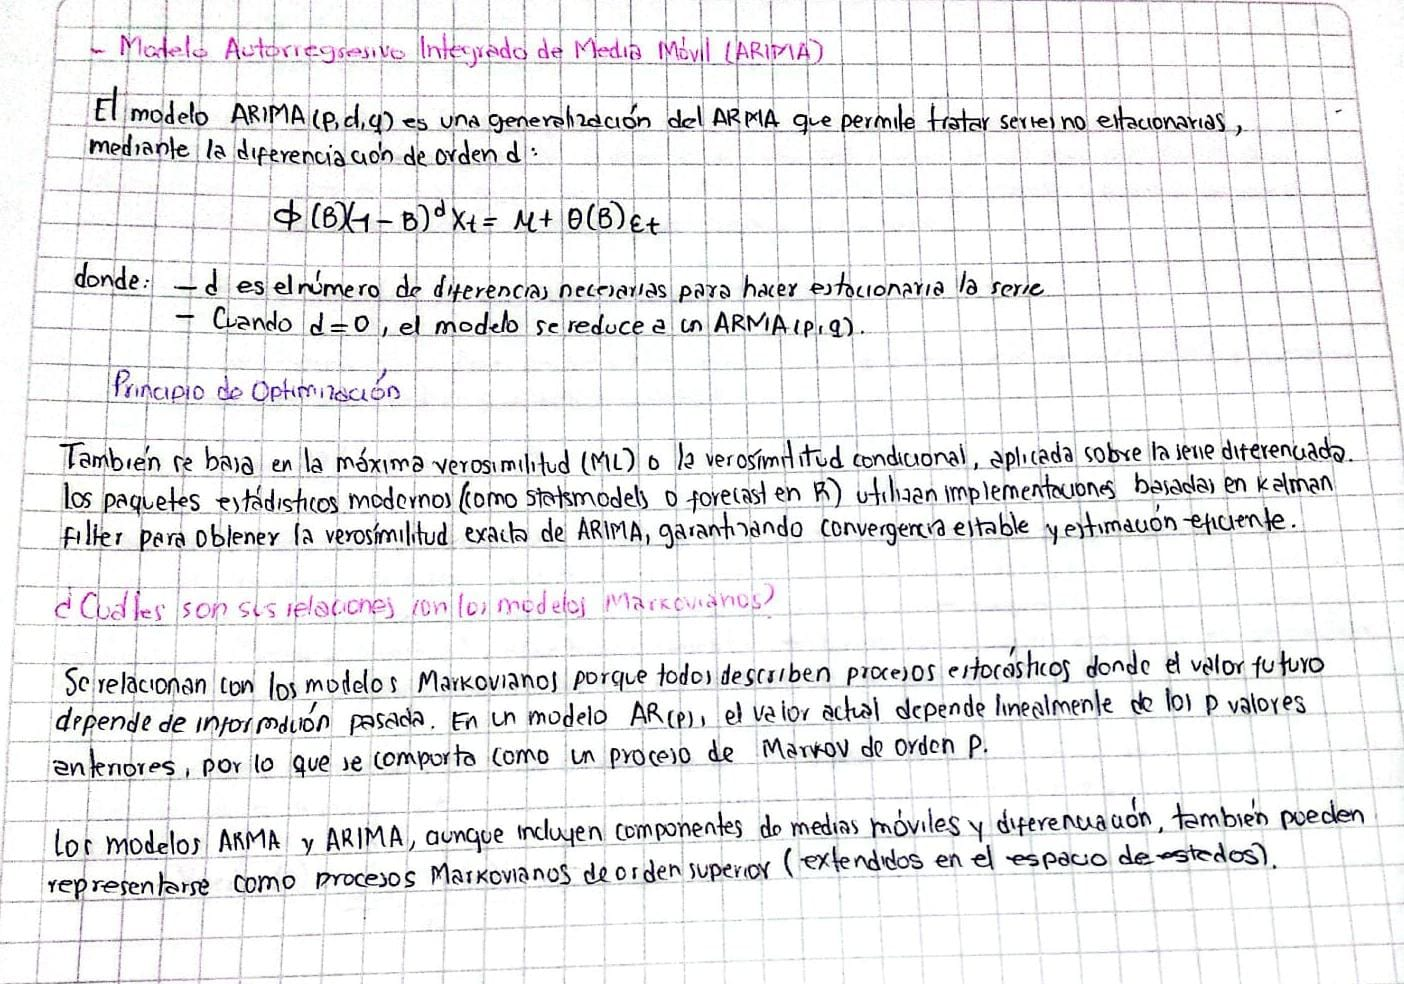

## Ejercicio 2
Para el modelo definido, determine los tamaños de las matrices y vectores de bias en cada capa.

**Nota**: Utilice el método `model.layers[l].get_weights()`

In [18]:
# Definición de número de steps y batch_size
n_steps = 50; batch_size = 10000
series  = generate_time_series(batch_size, n_steps + 1)
print('Series dimension:',series.shape)

# Partición de train/valid/test
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
print("Train:", X_train.shape, y_train.shape); print("Valid:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)

Series dimension: (10000, 51, 1)
Train: (7000, 50, 1) (7000, 1)
Valid: (2000, 50, 1) (2000, 1)
Test: (1000, 50, 1) (1000, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, None, 20)       │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

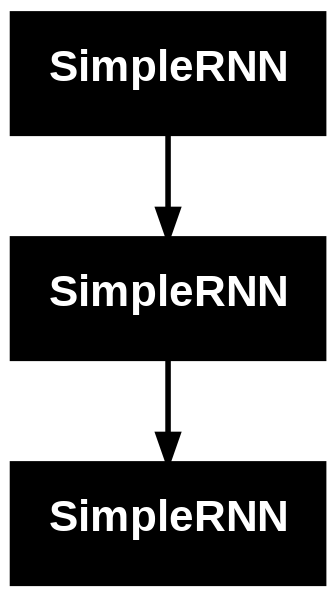

In [19]:
# Creación del modelo Deep RNN como un stack de SimpleRNN-
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1,activation='linear')])

# Diagrama de bloques del modelo
model.summary(); tf.keras.utils.plot_model(model)

In [20]:
# Compilación
model.compile(loss="mse", optimizer="adam")
# Entrenamiento
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0840 - val_loss: 0.0062
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

MSE: 0.31023884 %



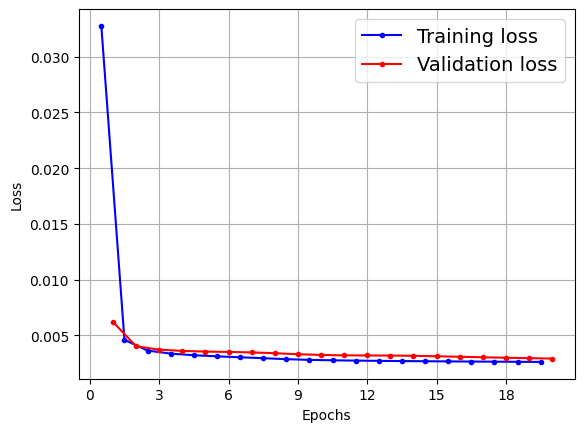

In [21]:
# Visualización curvas de aprendizaje
plot_learning_curves(history.history["loss"], history.history["val_loss"])
# Evaluación del modelo
y_pred = model.predict(X_test)
print('\nMSE:',np.mean(keras.losses.mse(y_test, y_pred))*100,'%\n')

In [22]:
# Lista con la información de pesos y bias
datos = []

for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    for j, w in enumerate(weights):
        datos.append({
            "Capa": layer.name,
            "Tipo de parámetro": ["kernel", "recurrent_kernel", "bias"][j],
            "Forma": str(w.shape),
            "Total parámetros": w.size})

# Convertir a DataFrame
df_pesos = pd.DataFrame(datos)

# Visualización de resultados
print("\nResumen de tamaños de matrices y vectores de bias:\n")
display(df_pesos)
print("\nTotal de parámetros por capa:")
display(df_pesos.groupby("Capa")["Total parámetros"].sum().reset_index())


Resumen de tamaños de matrices y vectores de bias:



,Capa,Tipo de parámetro,Forma,Total parámetros
0,simple_rnn_6,kernel,"(1, 20)",20
1,simple_rnn_6,recurrent_kernel,"(20, 20)",400
2,simple_rnn_6,bias,"(20,)",20
3,simple_rnn_7,kernel,"(20, 20)",400
4,simple_rnn_7,recurrent_kernel,"(20, 20)",400
5,simple_rnn_7,bias,"(20,)",20
6,simple_rnn_8,kernel,"(20, 1)",20
7,simple_rnn_8,recurrent_kernel,"(1, 1)",1
8,simple_rnn_8,bias,"(1,)",1



Total de parámetros por capa:


,Capa,Total parámetros
0,simple_rnn_6,440
1,simple_rnn_7,820
2,simple_rnn_8,22


## Ejercicio 3
- Consulte en qué consisten las capas Conv1D y cómo pueden aplicarse para modelar series temporales (Ver capa Conv1D y ejemplo).

- Realice una comparación entre las redes tipo RNN simple, LSTM, GRU y Conv1D en terminos de la capacidad de predicción en términos del mse y el mae, en los datos simulados para diferentes horizontes:  {1,2,3,…,15}

In [23]:
# Parámetros
np.random.seed(42); tf.random.set_seed(42); n_steps = 50
horizons = range(1, 16)  # 1 a 15 pasos futuros

# Generar datos
series = generate_time_series(10000, n_steps + max(horizons))
print('Series dimensions:',series.shape)
X_train, X_valid, X_test = series[:7000, :n_steps], series[7000:9000, :n_steps], series[9000:, :n_steps]
print('X_train dimensions:',X_train.shape); print('X_valid dimensions:',X_valid.shape); print('X_test dimensions:',X_test.shape)

Series dimensions: (10000, 65, 1)
X_train dimensions: (7000, 50, 1)
X_valid dimensions: (2000, 50, 1)
X_test dimensions: (1000, 50, 1)


In [24]:
# Definición de Modelos
def build_rnn():
    return keras.models.Sequential([
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.SimpleRNN(1)])

def build_lstm():
    return keras.models.Sequential([
        keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(1))])

def build_gru():
    return keras.models.Sequential([
        keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(1))])

def build_conv1d():
    return keras.models.Sequential([
        keras.layers.Conv1D(32, 5, padding="causal", activation="relu", input_shape=[None, 1]),
        keras.layers.Conv1D(32, 5, padding="causal", activation="relu"),
        keras.layers.Conv1D(1, 1)])

# Diccionario de modelos
model_builders = {
    "SimpleRNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Conv1D": build_conv1d}

In [25]:
# Entrenamiento y evaluación
results = []

for name, build_fn in model_builders.items():
    print(f"\n===== Entrenando modelo {name} =====")
    model = build_fn()
    model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

    # Entrenar solo una vez (para horizonte máximo)
    Y_train = get_Y_for_horizon(series[:7000], max(horizons))
    Y_valid = get_Y_for_horizon(series[7000:9000], max(horizons))
    Y_test  = get_Y_for_horizon(series[9000:], max(horizons))

    history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid), verbose=0)

    # Evaluar para cada horizonte
    for h in horizons:
        Y_test_h = get_Y_for_horizon(series[9000:], h)
        Y_pred = model.predict(X_test, verbose=0)

        mse = mean_squared_error(Y_test_h[:, -1], Y_pred[:, -1])
        mae = mean_absolute_error(Y_test_h[:, -1], Y_pred[:, -1])

        results.append({
            "Modelo": name,
            "Horizonte": h,
            "MSE": mse,
            "MAE": mae})

warnings.filterwarnings("ignore")


===== Entrenando modelo SimpleRNN =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



===== Entrenando modelo LSTM =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



===== Entrenando modelo GRU =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



===== Entrenando modelo Conv1D =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# Resultados a DataFrame
df_results = pd.DataFrame(results)
print("\n=== Resultados comparativos ===\n")
display(df_results.head(20))

# Promedios por modelo
promedios = df_results.groupby("Modelo")[["MSE", "MAE"]].mean().reset_index()
print("\n=== Promedios de error por modelo ===")
display(promedios)


=== Resultados comparativos ===



,Modelo,Horizonte,MSE,MAE
0,SimpleRNN,1,0.152409,0.338687
1,SimpleRNN,2,0.141768,0.326515
2,SimpleRNN,3,0.133167,0.314987
3,SimpleRNN,4,0.128195,0.309388
4,SimpleRNN,5,0.124496,0.303407
5,SimpleRNN,6,0.126722,0.303629
6,SimpleRNN,7,0.130035,0.308318
7,SimpleRNN,8,0.132632,0.314814
8,SimpleRNN,9,0.134712,0.319946
9,SimpleRNN,10,0.135715,0.322579



=== Promedios de error por modelo ===


,Modelo,MSE,MAE
0,Conv1D,0.209503,0.378253
1,GRU,0.270569,0.427119
2,LSTM,0.290131,0.442547
3,SimpleRNN,0.136083,0.318989


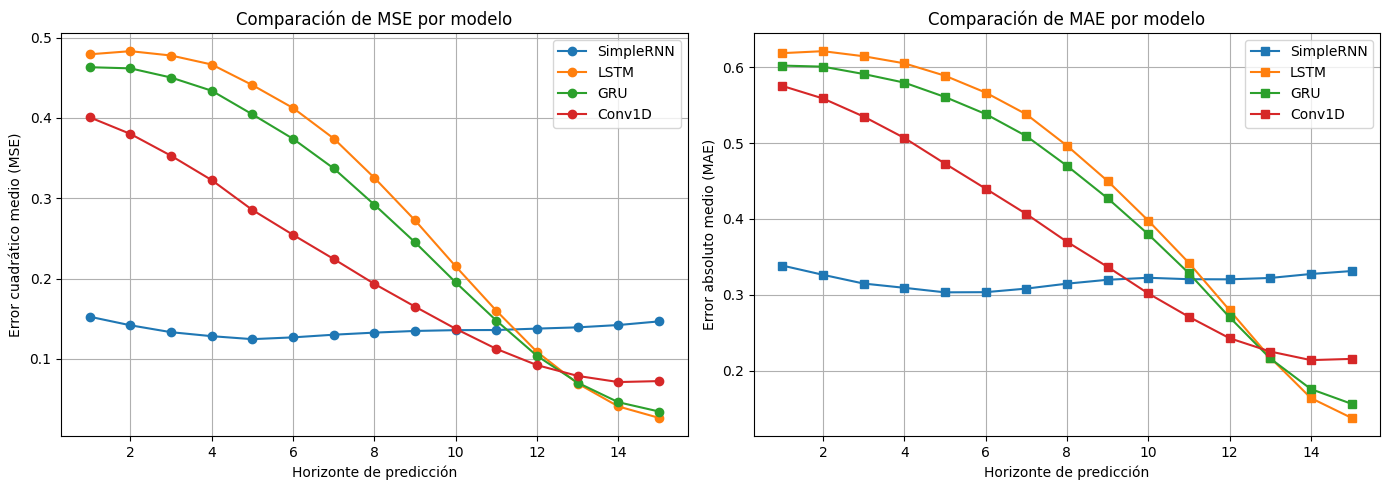

In [27]:
# Gráficas comparativas
plt.figure(figsize=(14, 5))
plt.subplot(121)
for name in model_builders.keys():
    subset = df_results[df_results["Modelo"] == name]
    plt.plot(subset["Horizonte"], subset["MSE"], marker='o', label=name)
plt.xlabel("Horizonte de predicción"); plt.ylabel("Error cuadrático medio (MSE)")
plt.title("Comparación de MSE por modelo"); plt.legend(); plt.grid(True)

plt.subplot(122)
for name in model_builders.keys():
    subset = df_results[df_results["Modelo"] == name]
    plt.plot(subset["Horizonte"], subset["MAE"], marker='s', label=name)
plt.xlabel("Horizonte de predicción"); plt.ylabel("Error absoluto medio (MAE)")
plt.title("Comparación de MAE por modelo"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

De acuerdo con los resultados de MSE y MAE para distintos horizontes de predicción, se observa que:

- SimpleRNN mantiene un error prácticamente constante y mayor, mostrando limitaciones para capturar dependencias a largo plazo.

- LSTM y GRU presentan una mejor capacidad de predicción a medida que aumenta el horizonte, con errores significativamente menores que la RNN simple.

- Conv1D logra un buen desempeño en varios horizontes, lo que indica que las convoluciones causales son efectivas para modelar patrones locales y dependencias temporales sin necesidad de recurrencias explícitas.

En conjunto, los modelos basados en memoria (LSTM y GRU) y Conv1D muestran una mayor capacidad de generalización y menor error tanto en MSE como en MAE, demostrando que son más adecuados para la predicción de series temporales que la RNN simple.